<font color='blue'> <p> __Project goals__: Using the prospect data, create different models and choose the best one to predict the likelihood a prospect will convert into residents</p > 
<p> __Methods used__: decision tree, navie bayes, random forest, logistic regression, LDA, PCA, clustering and cross validation </p >
<p>__Conclusions__: The best model is Decision Tree (criterion = 'entropy', max_depth = 7, min_samples_leaf = 2, min_samples_split = 20) with 49 features. The accuracy of cross validation is 0.91, and the fl score of predicting a prospect will convert into residents is 0.80</p >


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
df1 = pd.read_csv('Senior_Lifestyle_Data-DataSet1.txt', delimiter=" ")
df2 = pd.read_csv('Senior_Lifestyle_Data-DataSet2.txt', delimiter=" ")
df3 = pd.read_csv('Senior_Lifestyle_Data-DataSet3.txt', delimiter=" ")
df4 = pd.read_csv('Senior_Lifestyle_Data-DataSet4.txt', delimiter=" ")

In [13]:
df1.shape

(178478, 24)

In [11]:
df1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CommunityCode,164549,NaN,NaN,NaN,594.088,180.166,272,458,503,740,899
CommunityZipCode,164549,NaN,NaN,NaN,50576.7,24091.1,6413,33021,53129,73135,99324
ProspectID,178478,178478,6216568d-6c37-e811-8113-e0071b6a8141,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeatInquiry,101838,NaN,NaN,NaN,81.5732,9.64054,-31,76,83,88,185
CareLevel,169672,5,A,72305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,174805,2,Female,112344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,17023,4,Married,8310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veteran,178478,2,False,101307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CurrentResidence,36868,4,Living at Home,24875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZipCode,63631,NaN,NaN,NaN,51561.6,24374,1002,33028,53129,76502,99801


# <font color='blue'> <p> Data Preprocessing

<font color='blue'> Except AgeatInquiry, all of the variables are categorical variables. 

## <font color='blue'> <p> Merge dataframe df1, df2 and df3
### <font color='blue'> <p>df2 transformation
<font color='blue'> <p>Df2 shows the sales activities. There might be several sales activities of the company for each prospect. We want to get a dataset that can shows the number of each sales activity for every prospect. Those information could be the additional features of our model.

In [3]:
# Original df2
df2.head()

,ProspectID,Activity,dtActivity
0,00004e5d-d6ca-e511-80ef-3863bb36cca0,Personal Letter,2016-02-09 08:00:00
1,00004e5d-d6ca-e511-80ef-3863bb36cca0,Call,2016-03-05 08:00:00
2,00004e5d-d6ca-e511-80ef-3863bb36cca0,Email,2016-02-03 18:29:36
3,00004e5d-d6ca-e511-80ef-3863bb36cca0,Call,2016-03-24 07:00:00
4,00004e5d-d6ca-e511-80ef-3863bb36cca0,Email,2016-03-24 07:00:00


In [141]:
df2_trans = pd.DataFrame(columns = ['ProspectID', 'PersonalLetter', 'Call', 'Email', 'Tour', 'Visit', 'Assessment',
       'CommunityEvent', 'MassCommunication', 'TextMessage',
       'ShortStay', 'Gift'])
m = 0
for i in df2.ProspectID.unique():
    df_new = df2.loc[df2['ProspectID'] == i]
    List = []
    try:
        Personal_Letter = df_new.Activity.value_counts()['Personal Letter'] 
    except KeyError:
        Personal_Letter = 0
    try:
        Call = df_new.Activity.value_counts()['Call']
    except KeyError:
        Call = 0
    try:
        Email = df_new.Activity.value_counts()['Email']
    except KeyError:
        Email = 0
    try:
        Tour = df_new.Activity.value_counts()['Tour']
    except KeyError:
        Tour = 0
    try:
        Visit = df_new.Activity.value_counts()['Visit']
    except KeyError:
        Visit = 0
    try:
        Assessment = df_new.Activity.value_counts()['Assessment']
    except KeyError:
        Assessment = 0
    try:
        Community_Event = df_new.Activity.value_counts()['Community Event']
    except KeyError:
        Community_Event = 0
    try:
        Mass_Communication = df_new.Activity.value_counts()['Mass Communication']
    except KeyError:
        Mass_Communication = 0
    try:
        Text_Message = df_new.Activity.value_counts()['Text Message']
    except KeyError:
        Text_Message = 0
    try:
        Short_Stay = df_new.Activity.value_counts()['Short Stay']
    except KeyError:
        Short_Stay = 0
    try:
        Gift = df_new.Activity.value_counts()['Gift']
    except KeyError:
        Gift = 0
    List = [i, Personal_Letter, Call, Email, Tour, Visit, Assessment,
       Community_Event, Mass_Communication, Text_Message,
       Short_Stay, Gift]
    df2_trans.loc[m] = List
    m += 1

In [144]:
df2_trans.shape

(143069, 12)

In [143]:
df2_trans.to_csv("df2_trans.csv", float_format="%1.2f")

In [4]:
df2_trans = pd.read_csv('df2_trans.csv')
df2_trans.drop(['Unnamed: 0'], inplace=True, axis = 1)

In [5]:
# df2 after transformation
df2_trans.head()

,ProspectID,Personal Letter,Call,Email,Tour,Visit,Assessment,Community Event,Mass Communication,Text Message,Short Stay,Gift
0,00004e5d-d6ca-e511-80ef-3863bb36cca0,1,2,2,1,0,0,0,0,0,0,0
1,00005ac8-1d93-e611-80e9-5065f38a3b81,0,0,1,0,0,0,0,0,0,0,0
2,0000d788-d370-e411-bfcd-6c3be5a8a144,0,4,8,0,0,0,0,0,0,0,0
3,00022c39-0826-45c3-969d-653e1cd0e652,0,1,0,0,0,0,0,0,0,0,0
4,0002bef2-ff5f-e611-8106-3863bb2eb148,0,1,2,0,0,0,0,0,0,0,0


### <font color='blue'> <p>df3 transformation
<font color='blue'> <p>Since df3 displays the significant date prospect converted into residents, we assume all the records in df3 are prospects already moved in, so we add a new column "moveIn" to df3, assigned its value to 1. Then we creat a new dataframe df1_3 by merging df1 and df3 together. For all the records have missing value under column 'moveIn', we assign its value to 0, indicating prospects did not move in.

In [7]:
new_col = np.ones(5738)
df3_tran = df3.assign(moveIn = new_col)
df3_tran = df3_tran.drop(['ResidentID', 'dtmovein','dtmoveout', 'istatus','ireason'], axis = 1)

df1_3 = df1.merge(df3_tran, on='ProspectID', how='left')
df1_3['moveIn'].fillna(0, inplace=True)
df1_3.head()

,CommunityCode,CommunityZipCode,ProspectID,AgeatInquiry,CareLevel,Gender,Marital,Veteran,CurrentResidence,ZipCode,...,NoCall,NoEmail,InquiryDate,ReferralCompany,ProjectedMoveIn,DeactDate,DeactReason,NotQual,CurrentStatus,moveIn
0,731.0,54311.0,0f0d9652-7697-4d03-84da-000137b878db,NaN,A,Female,NaN,False,NaN,NaN,...,False,False,2011-04-15 17:54:00,SeniorLiving.net,NaN,2012-09-18 05:00:00,Request Removal,NaN,Deactivated,0.0
1,415.0,60010.0,59a04927-19ee-42de-840f-545a4e8b5533,77.0,I,Female,Widow,False,Living at Home,NaN,...,False,True,2012-12-17 20:29:00,A Place for Mom,NaN,2013-01-19 06:00:00,NaN,NaN,Deactivated,0.0
2,491.0,30052.0,87305eb0-2ed2-430c-9b4e-00019a38134a,NaN,NaN,Female,NaN,False,NaN,NaN,...,False,True,2014-09-23 04:00:00,A Place for Mom,NaN,2014-12-17 05:00:00,Duplicate Lead,NaN,Deactivated,0.0
3,775.0,33462.0,50dd6777-4333-48bb-9ac5-00041d493ef0,NaN,NaN,Female,NaN,False,NaN,NaN,...,True,True,2013-10-17 04:00:00,Caring.com,NaN,2013-10-17 04:00:00,Duplicate Lead,NaN,Deactivated,0.0
4,492.0,33021.0,f7ce16ab-bbaf-45ae-be5b-0004e020269f,NaN,A,Female,NaN,False,NaN,NaN,...,False,True,2013-10-22 04:00:00,Caring.com,NaN,2014-12-24 05:00:00,Not Qualified,NaN,Deactivated,0.0


In [147]:
df1_3.shape

(178538, 25)

In [148]:
df2_trans.shape

(143069, 12)

In [40]:
df_total = df1_3.merge(df2_trans, on='ProspectID', how='left')

In [41]:
df_total.shape

(178538, 36)

## <font color='blue'> <p> Missing Value
<font color='blue'> <p> ID, zipcode and date should not be in the model.
So communityCode, CommunityZipCode, ZipCode, DeactDate, ProjectedMoveIn, ProspectID, InquiryDate, NotQual, CurrentStatus and InquiryDate should be dropped

In [42]:
df_total.drop(['CommunityCode', 'CommunityZipCode','ZipCode', 'DeactDate','ProjectedMoveIn', 'ProspectID', 'InquiryDate', 'NotQual', 'DeactReason', 'CurrentStatus'], inplace=True, axis = 1)

In [43]:
df_total.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AgeatInquiry,101876,NaN,NaN,NaN,81.5717,9.65048,-31,76,83,88,185
CareLevel,169732,5,A,72328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,174865,2,Female,112384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,17035,4,Married,8314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veteran,178538,2,False,101338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CurrentResidence,36888,4,Living at Home,24885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPreference,6141,6,1 Bed,3108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedEmail,178538,2,False,144049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedPhone,178538,2,False,139449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Budget,111978,6,"3,000-4,000",30923,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='blue'> <p> Categorical Variable missing values (moveIn = 0)
<font color='blue'> <p>Since the proportion of prospects did not move In is higher than prospects moved In, and we focus more on moveIn records. So if the varable is prospect not move in and contains missing value, we will drop the missing value directly. Otherwise, we will keep the missing value for further operation. After this step, the dataframe contains 25,656 records.

In [44]:
# AgeatInquiry
for inx in df_total[df_total.AgeatInquiry.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue
        
# CareLevel
for inx in df_total[df_total.CareLevel.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue
        
# Gender
for inx in df_total[df_total.Gender.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue

# Budget
for inx in df_total[df_total.Budget.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue

# Call
for inx in df_total[df_total.Call.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue
        
#CurrentResidence
for inx in df_total[df_total.CurrentResidence.isnull()].index:
    if df_total.loc[inx]['moveIn'] == 0:
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue

In [50]:
df_total.shape

(25656, 27)

### <font color='blue'> <p> Other variables
<font color='blue'> <p>For other varables we do the data cleaning according to the following steps:

1) Remove outliers

For numerical attribute 'AgeatInquiry', we can see either from its boxplot or historgram, it has outliers like negative value. so we utilze IQR method to remove these outliers. After this process, the dataframe has 23,711 records.

2) Missing Values

For attributes 'UnitPreference' and 'Marital', since their missing values amounts are large, if they have missing values, we consider customers have no preference or not intend to disclose marriage status, so we will fill all their missing value as 'Unknown'
For numberical attributes 'AgeatInquiry', we fill in its missing value with its mean value. For other categorical variables, we fill in their missing value with their modes.

In [51]:
# treat the missing values in UnitPreference and Marital as Unknown 
df_total['UnitPreference'].fillna('Unknown', inplace=True)
df_total['Marital'].fillna('Unknown', inplace=True)

In [8]:
#the number of missing values
missing = pd.DataFrame(df_total.isnull().sum()) #sum(): point out how many missing values exist in the collection
missing[missing[0]>0]

,0
AgeatInquiry,1757
CareLevel,118
Gender,15
CurrentResidence,3157
Budget,2059
PersonalLetter,877
Call,877
Email,877
Tour,877
Visit,877


In [55]:
df_total.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AgeatInquiry,23899,NaN,NaN,NaN,81.5969,10.8419,-14,77,83,88,185
CareLevel,25538,5,A,9777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,25641,2,Female,15866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,25656,5,Unknown,20997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veteran,25656,2,True,17446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CurrentResidence,22499,4,Living at Home,14887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPreference,25656,7,Unknown,23430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedEmail,25656,2,False,20795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedPhone,25656,2,False,19438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Budget,23597,6,"3,000-4,000",6567,NaN,NaN,NaN,NaN,NaN,NaN,NaN


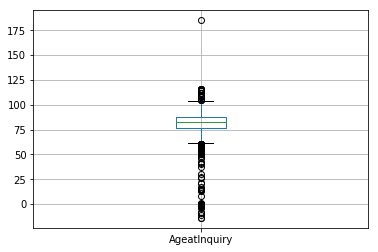

In [57]:
df_total.boxplot(column='AgeatInquiry')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125fe5320>]], dtype=object)

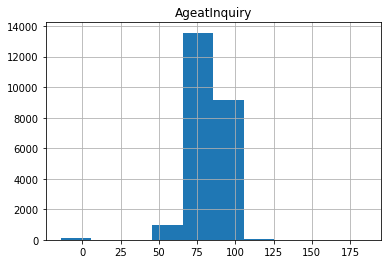

In [58]:
df_total.hist(column='AgeatInquiry')

In [132]:
df_total = pd.read_csv('df_total.csv')

In [133]:
# There are a lot of outliners including some wrong numbers like negative values. We use IQR method to remove them
# Also if the instance moves in, we will keep it
Q1 = df_total['AgeatInquiry'].quantile(0.25)
Q3 = df_total['AgeatInquiry'].quantile(0.75)
IQR = Q3 - Q1

for inx in df_total.index:
    if df_total.loc[inx]['AgeatInquiry'] < Q1 - 1.5*(IQR):
        df_total.drop([inx], axis=0, inplace=True)
    elif df_total.loc[inx]['AgeatInquiry'] > Q1 + 1.5*(IQR):
        df_total.drop([inx], axis=0, inplace=True)
    else:
        continue

In [129]:
df_total.shape

(23711, 27)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127501358>]], dtype=object)

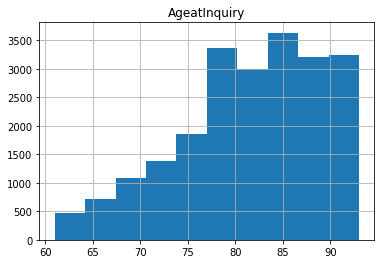

In [130]:
df_total.hist(column='AgeatInquiry')

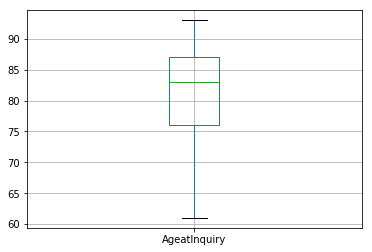

In [112]:
df_total.boxplot(column='AgeatInquiry')

In [134]:
df_total.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AgeatInquiry,21954,NaN,NaN,NaN,81.4616,7.50701,61,76,83,87,93
CareLevel,23594,5,A,8920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,23697,2,Female,14606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,23711,5,Unknown,19381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veteran,23711,2,True,16015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CurrentResidence,20800,4,Living at Home,13957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPreference,23711,7,Unknown,21627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedEmail,23711,2,False,19074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedPhone,23711,2,False,17826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Budget,21731,6,"3,000-4,000",6026,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
df_total.moveIn.value_counts()

0    18444
1     5267
Name: moveIn, dtype: int64

In [135]:
###fit missing value
##fit numerical missing value
#fit age
A_M = df_total.AgeatInquiry.mean()
A_M = round(A_M,2)
df_total.AgeatInquiry.fillna(A_M, axis=0, inplace=True)
#fit target 
df_total.PersonalLetter.fillna(0, axis=0, inplace=True)
df_total.Call.fillna(0, axis=0, inplace=True)
df_total.Email.fillna(0, axis=0, inplace=True)
df_total.Tour.fillna(0, axis=0, inplace=True)
df_total.Visit.fillna(0, axis=0, inplace=True)
df_total.Assessment.fillna(0, axis=0, inplace=True)
df_total.CommunityEvent.fillna(0, axis=0, inplace=True)
df_total.MassCommunication.fillna(0, axis=0, inplace=True)
df_total.TextMessage.fillna(0, axis=0, inplace=True)
df_total.ShortStay.fillna(0, axis=0, inplace=True)
df_total.Gift.fillna(0, axis=0, inplace=True)
##fit categorical missing value with MOD
#fit CareLevel
df_total.CareLevel.fillna('A', axis=0, inplace=True)
#fit Gender
df_total.Gender.fillna('Female', axis=0, inplace=True)
#fit Budget
df_total.Budget.fillna('3,000-4,000', axis=0, inplace=True)
#fit CurrentResidence
df_total.CurrentResidence.fillna('Living at Home', axis=0, inplace=True)
#df_total.isnull().values.any()

In [212]:
df_total.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AgeatInquiry,23711,NaN,NaN,NaN,81.4615,7.22351,61,77,82,87,93
CareLevel,23711,5,A,9037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,23711,2,Female,14620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital,23711,5,Unknown,19381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veteran,23711,2,True,16015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CurrentResidence,23711,4,Living at Home,16868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPreference,23711,7,Unknown,21627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedEmail,23711,2,False,19074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProvidedPhone,23711,2,False,17826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Budget,23711,6,"3,000-4,000",8006,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [435]:
df_final = pd.read_csv('df_final_with_currentstatus.csv')

## <font color='blue'> <p>Data Visualization
### <font color='blue'> <p>Histogram for Numerical variable
#### <font color='blue'> <p>Observations:
<font color='blue'> <p>1) As we can see in AgeatInquiry Histogram, its distribution is skew to the left, indicating it has outliers on the left side; Combine its statistic results, we can conclude that customer at elder age (around 78~82) are more likely to inquiry for prospect, but this does not indicate the direct correlationship between 'moveIn' and 'age', we need do further analysis for this attribute.

2) For other Categorical attributes Histogram, which are sales activities initiate during sale process, we can find out most of the sales activities are concentrate at first bin, indicating company didn't host more follow up activity.

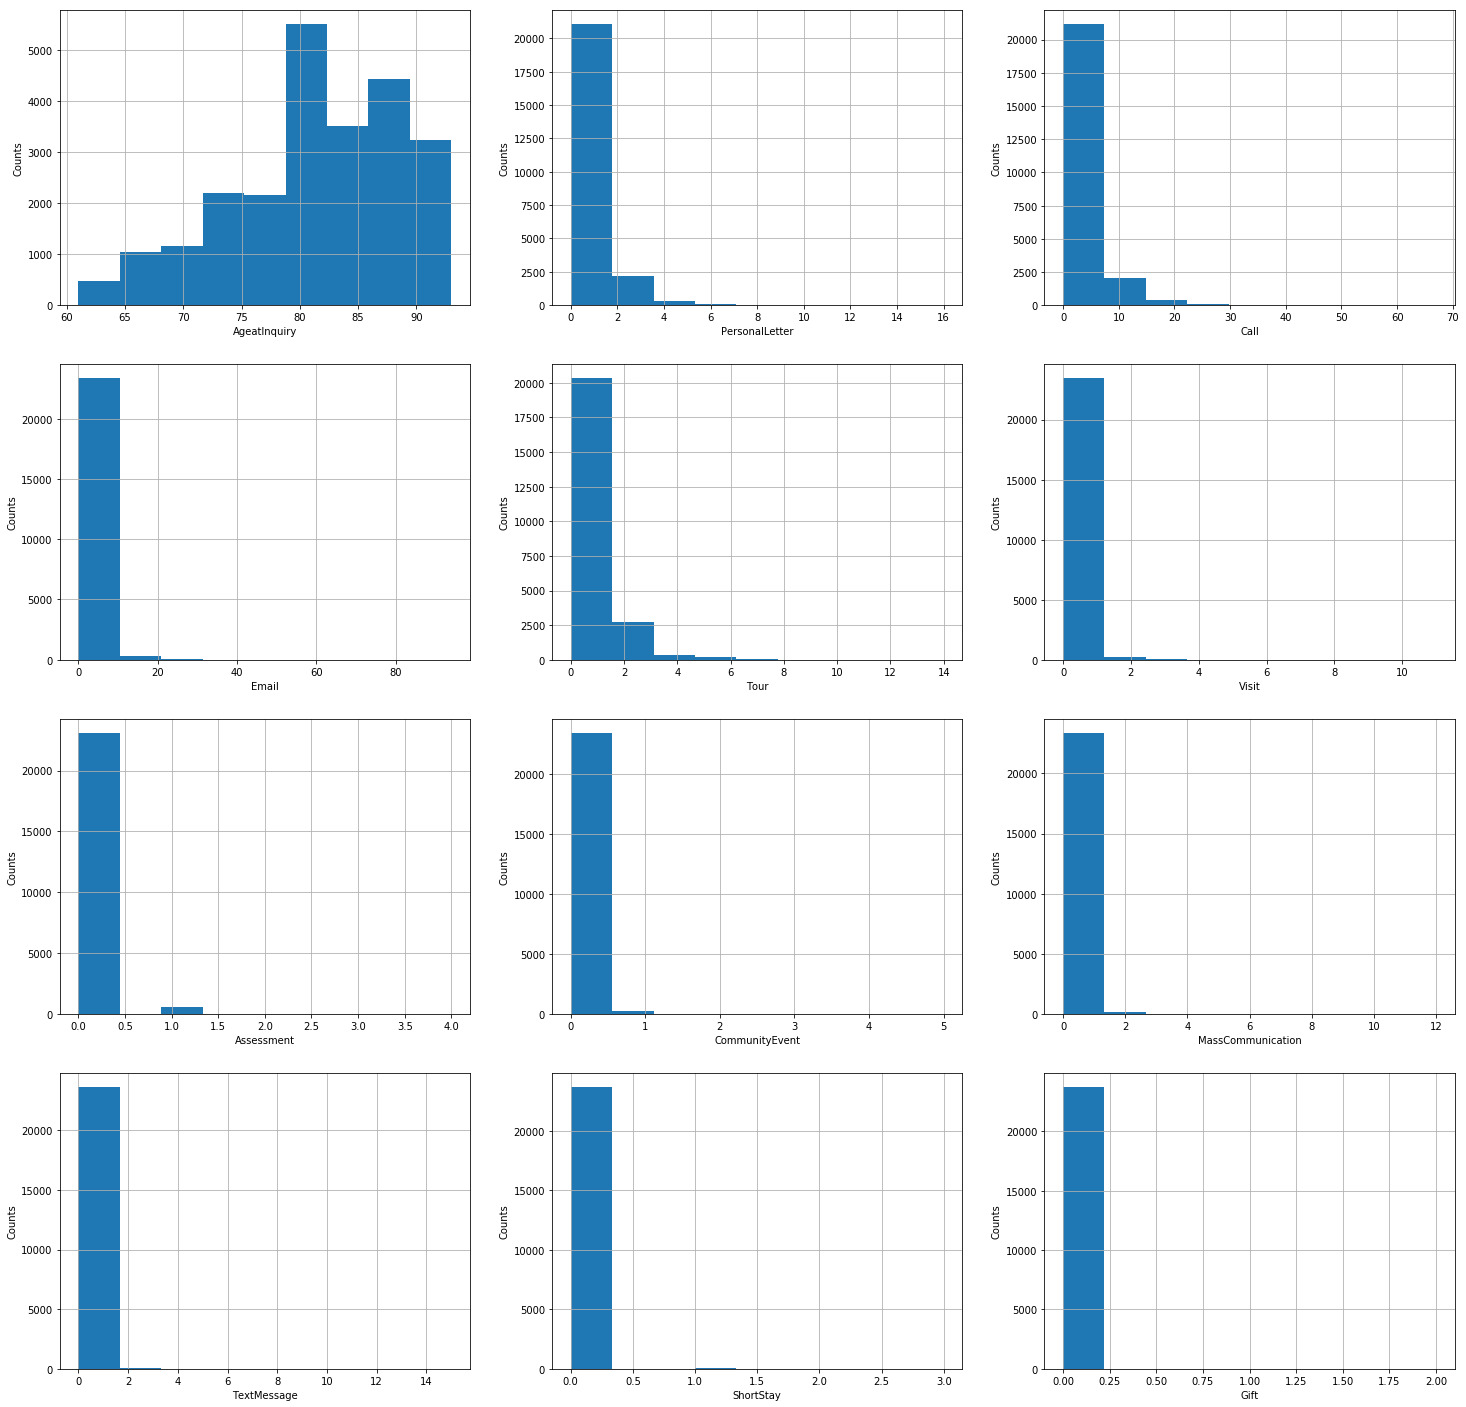

In [436]:
# Histogram for Numerical variable
fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(4,3,1)
df_final['AgeatInquiry'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('AgeatInquiry')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,2)
df_final['PersonalLetter'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('PersonalLetter')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,3)
df_final['Call'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Call')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,4)
df_final['Email'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Email')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,5)
df_final['Tour'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Tour')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,6)
df_final['Visit'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Visit')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,7)
df_final['Assessment'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Assessment')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,8)
df_final['CommunityEvent'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('CommunityEvent')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,9)
df_final['MassCommunication'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('MassCommunication')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,10)
df_final['TextMessage'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('TextMessage')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,11)
df_final['ShortStay'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('ShortStay')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,3,12)
df_final['Gift'].plot(kind = 'hist', bins = 9, grid = True)
ax1.set_xlabel('Gift')
ax1.set_ylabel('Counts')



### <font color='blue'> <p>Crosstab for Categorical Variables and Target Variable: moveIn
#### <font color='blue'> <p>Observations:
<font color='blue'> <p>1) CareLevel: data are concentrate at carelevel A, people at carelevel F has less tend to moveIn

2) Gender: data are concentrate at Female, and Male has higher probabilty to move in

3) Marital: data are concentrat at Unknow, and the move in possibility are lowest among other category, indicating unknown marital people are less likely to move in after prospect

4) Veteran: data are concentrat at True, but Veteran status under False has higher possible to move in

5) CurrentResidence: data are concentrat at Living at Home, and people under this category has higest possible to move in

6) UnitPreference: data are concentrat at Unknown, people under this category has lowest possible to move in; people under 1 Bed and Studio has higher possible to move in

7) ProvidedEmail: data are concentrat at False, but bar chart here indicate people do not provide email has higher possible to move in

8) ProvidedPhone: data are concentrat at False, people provide phone has higher possible to move in

9) Budget: data are concentrat at 3000-4000, people has this budget has higher possible to move in

10) RequestedVisit: data are concentrat at False, people did not request visit has higher possible to move in

11) NoCall: data are concentrat at False, but people opt out receive call has higher possible to move in

12) NoEmail: data are concentrat at False, but people opt out receive email has higher possible to move in 

13) ReferralCompany: data are concentrat at A Piece of Mom, and people get reffered from Carring.com has the lowest possibility to move in

14) CurrentStatus: data are concentrat at Deactivated, and all the people's current status under move in indicate the positve relationship with attribute move in, and the other status indicate the negative relationship with attribute move in, that means currentstatus direct relate to moveIn, it's not a factor impact our target attribute, we can drop it when we do further analysis.

In [429]:
df_final.columns

Index(['AgeatInquiry', 'Veteran', 'ProvidedEmail', 'ProvidedPhone',
       'RequestedVisit', 'NoCall', 'NoEmail', 'PersonalLetter', 'Call',
       'Email', 'Tour', 'Visit', 'Assessment', 'CommunityEvent',
       'MassCommunication', 'TextMessage', 'ShortStay', 'Gift', 'CareLevel_A',
       'CareLevel_F', 'CareLevel_I', 'CareLevel_M', 'CareLevel_S',
       'Gender_Female', 'Gender_Male', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Unknown', 'Marital_Widow',
       'CurrentResidence_Living at Home',
       'CurrentResidence_Living with Family',
       'CurrentResidence_Rental Apartment',
       'CurrentResidence_Senior Community', 'UnitPreference_1 Bed',
       'UnitPreference_2 Bed', 'UnitPreference_3 Bed',
       'UnitPreference_Cottage/Villa', 'UnitPreference_Semi-Private',
       'UnitPreference_Studio', 'UnitPreference_Unknown', 'Budget_0-1,000',
       'Budget_1,000-2,000', 'Budget_2,000-3,000', 'Budget_3,000-4,000',
       'Budget_4,000-5,000', 'Budget

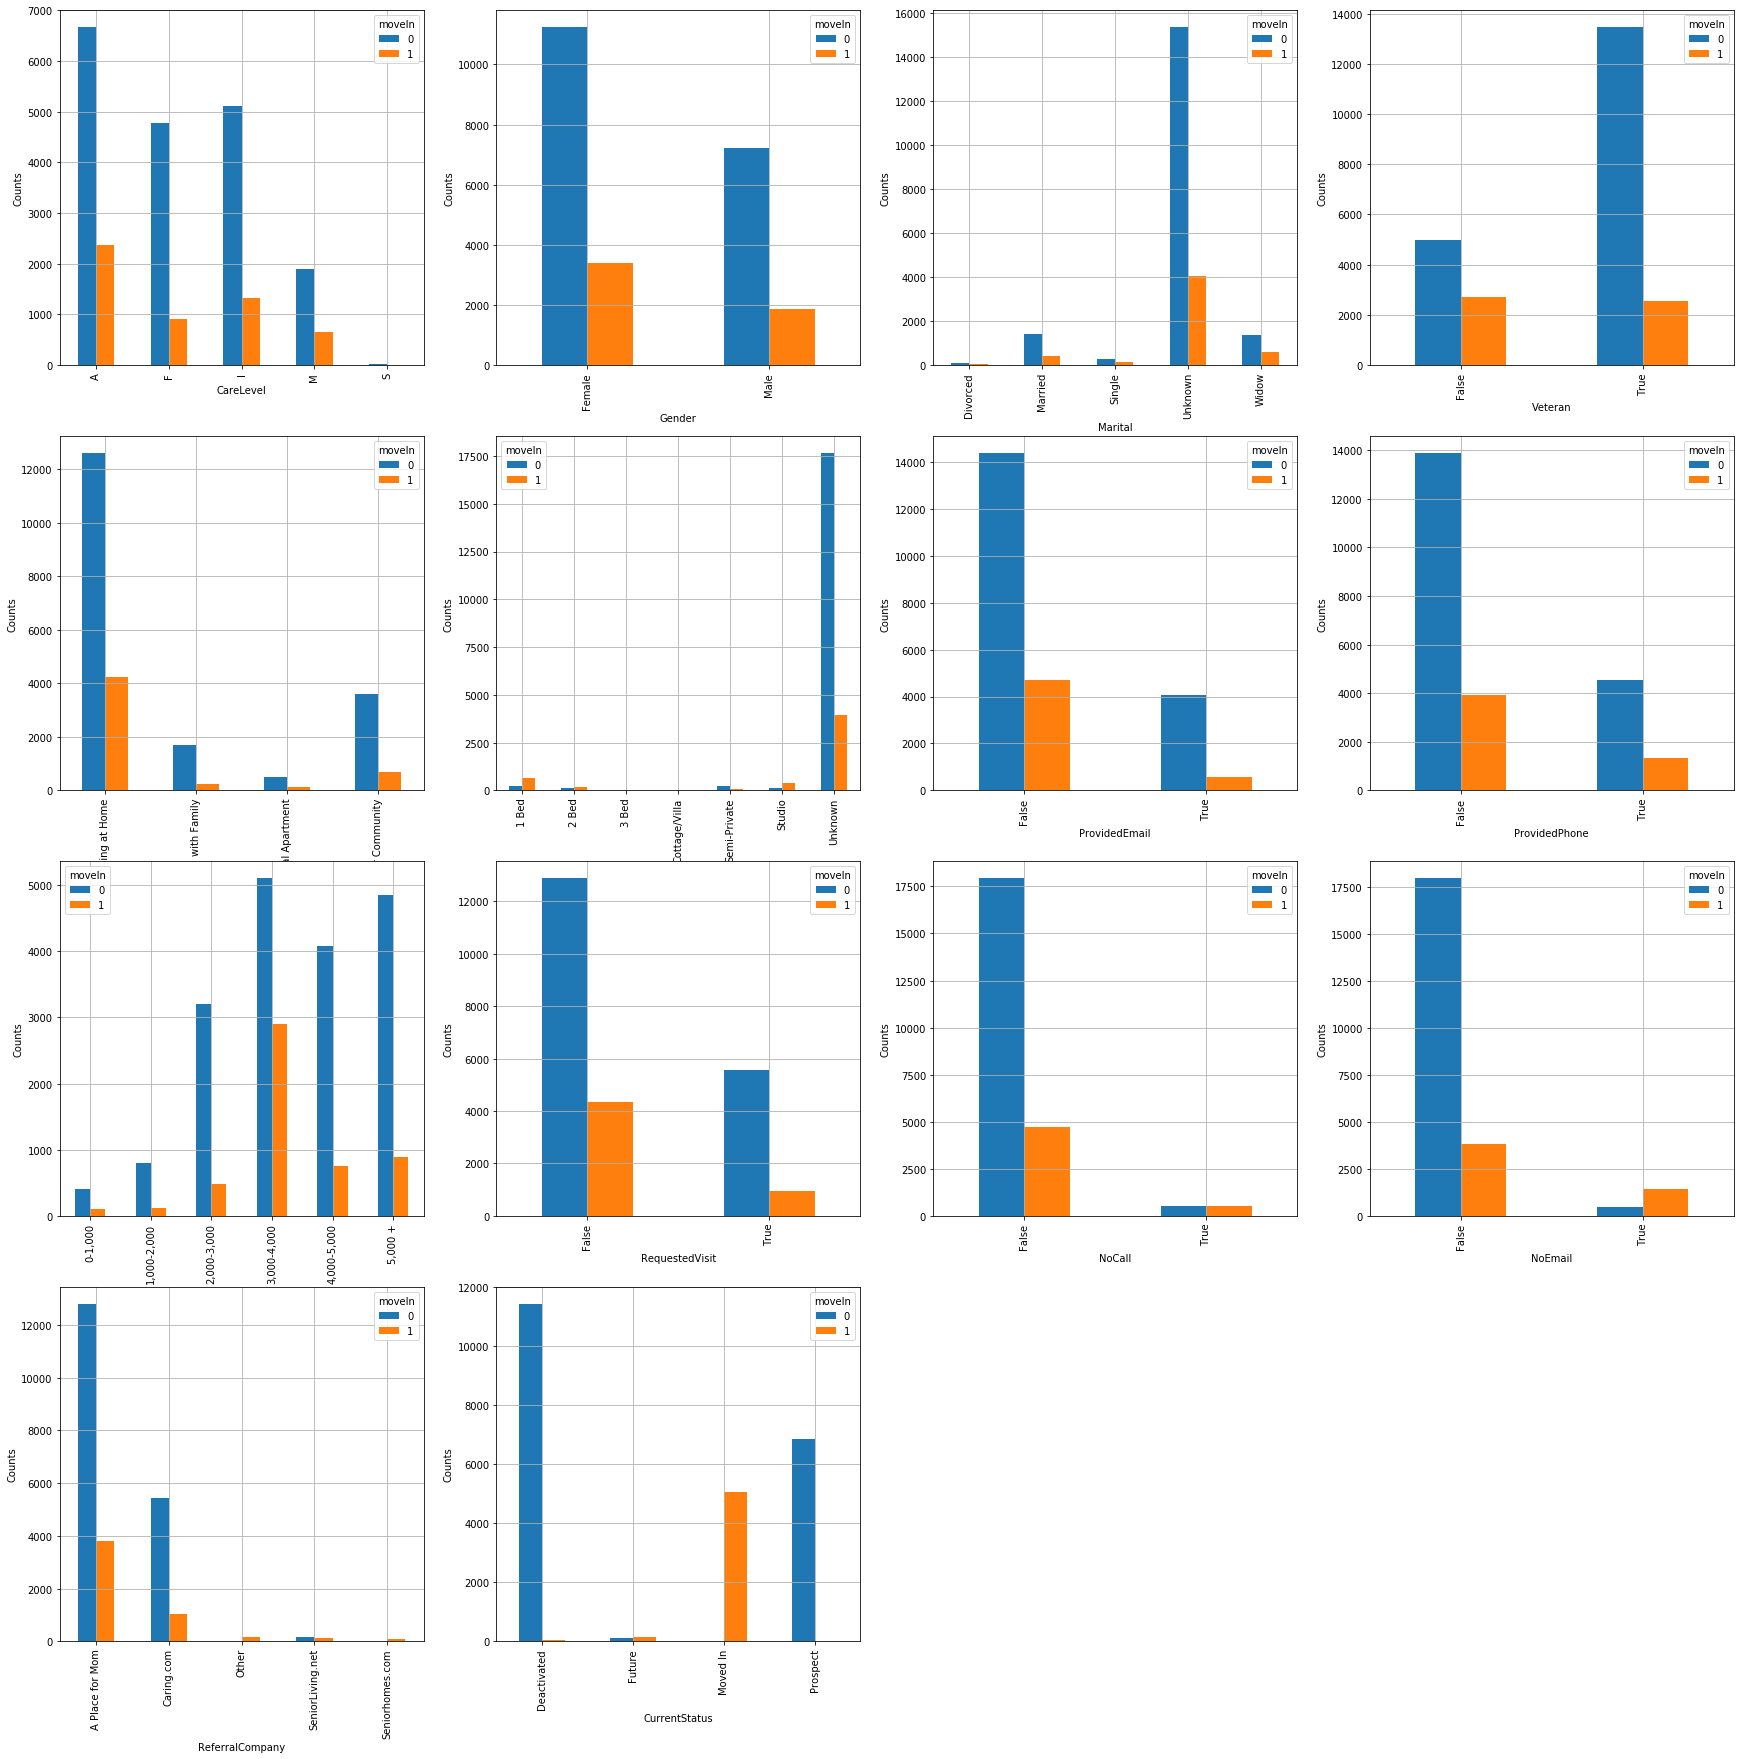

In [438]:
fig = plt.figure(figsize=(30,30))

ax1 = fig.add_subplot(4,4,1)
df_crosstab1 = pd.crosstab(df_final['CareLevel'], df_final['moveIn'])
df_crosstab1.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('CareLevel')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,2)
df_crosstab2 = pd.crosstab(df_final['Gender'], df_final['moveIn'])
df_crosstab2.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,3)
df_crosstab3 = pd.crosstab(df_final['Marital'], df_final['moveIn'])
df_crosstab3.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('Marital')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,4)
df_crosstab4 = pd.crosstab(df_final['Veteran'], df_final['moveIn'])
df_crosstab4.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('Veteran')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,5)
df_crosstab5 = pd.crosstab(df_final['CurrentResidence'], df_final['moveIn'])
df_crosstab5.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('CurrentResidence')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,6)
df_crosstab6 = pd.crosstab(df_final['UnitPreference'], df_final['moveIn'])
df_crosstab6.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('UnitPreference')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,7)
df_crosstab7 = pd.crosstab(df_final['ProvidedEmail'], df_final['moveIn'])
df_crosstab7.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('ProvidedEmail')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,8)
df_crosstab8 = pd.crosstab(df_final['ProvidedPhone'], df_final['moveIn'])
df_crosstab8.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('ProvidedPhone')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,9)
df_crosstab9 = pd.crosstab(df_final['Budget'], df_final['moveIn'])
df_crosstab9.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('Budget')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,10)
df_crosstab10 = pd.crosstab(df_final['RequestedVisit'], df_final['moveIn'])
df_crosstab10.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('RequestedVisit')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,11)
df_crosstab11 = pd.crosstab(df_final['NoCall'], df_final['moveIn'])
df_crosstab11.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('NoCall')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,12)
df_crosstab12 = pd.crosstab(df_final['NoEmail'], df_final['moveIn'])
df_crosstab12.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('NoEmail')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,13)
df_crosstab13 = pd.crosstab(df_final['ReferralCompany'], df_final['moveIn'])
df_crosstab13.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('ReferralCompany')
ax1.set_ylabel('Counts')

ax1 = fig.add_subplot(4,4,14)
df_crosstab14 = pd.crosstab(df_final['CurrentStatus'], df_final['moveIn'])
df_crosstab14.plot(kind = 'bar', grid = True, ax = ax1)
ax1.set_xlabel('CurrentStatus')
ax1.set_ylabel('Counts')

# <font color='blue'> <p> Splitting and Normalization

In [439]:
df_final = df_total

In [229]:
target = df_final.moveIn
df_final = df_final.drop(['moveIn'], axis=1)
#convert the data to dummy variables
df_final = pd.get_dummies(df_final)
df_final = df_final.astype(int)

In [230]:
from sklearn.cross_validation import train_test_split
train, test, target_train, target_test = train_test_split(df_final, target, test_size=0.2, random_state=33)

In [231]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(train)
train_norm = min_max_scaler.fit_transform(train)
test_norm = min_max_scaler.fit_transform(test)

In [254]:
train_norm.shape

(18968, 52)

# <font color='blue'> <p>Modeling
<font color='blue'> <p>We use five methods to build models, decision tree, logistic regression, naive bayes, random forest and linear discriminant analysis, and then evaluate each one of them using classification report and cross validation.

We have 52 variables, so we need to do feature selection or decomposition. Before that we want to use all of the variables first to see whether the performance improves after doing dimension reduction

## Building models with all variables

In [233]:
# Decision Tree
from sklearn import tree
treeclf = tree.DecisionTreeClassifier()
treeclf.fit(train, target_train)
treepreds_test = treeclf.predict(test)

In [370]:
# Using grid_search to choose the best model
from sklearn.grid_search import GridSearchCV

treeclf = tree.DecisionTreeClassifier()

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': np.array([int(e) for e in np.linspace(1, 20, 10)]),
    'min_samples_leaf': np.array([int(e) for e in np.linspace(2, 30, 20)]),
    'min_samples_split': np.array([int(e) for e in np.linspace(2, 20, 10)])
}

gs = GridSearchCV(treeclf, parameters, verbose=1, cv=5)

In [371]:
%time _ = gs.fit(train_norm, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
CPU times: user 14min 26s, sys: 52.4 s, total: 15min 18s
Wall time: 15min 19s


[Parallel(n_jobs=1)]: Done 20000 out of 20000 | elapsed: 15.3min finished


({'criterion': 'entropy',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'min_samples_split': 20},
 0.9106389708983551)

In [372]:
# fit the best parameters into decision tree
treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_leaf = 2, min_samples_split = 20)

treeclf.fit(train_norm, target_train)

#Using cross validation to come out the accuracy
from sklearn import cross_validation
cv_scores_tree = cross_validation.cross_val_score(treeclf, train_norm, target_train, cv=10)
print("Decision tree Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_tree.mean(), cv_scores_tree.std() * 2))

Decision tree Overall Accuracy: 0.91 (+/- 0.01)


In [373]:
from sklearn.metrics import classification_report
treepreds_test = treeclf.predict(test_norm)
print(classification_report(target_test, treepreds_test))

             precision    recall  f1-score   support

          0       0.94      0.92      0.93      3661
          1       0.74      0.79      0.77      1082

avg / total       0.89      0.89      0.89      4743



In [329]:
# Logistic Regression  
from sklearn.linear_model import LogisticRegression   

LRclf = LogisticRegression()

parameters = {
    'penalty': ['l2','l1']
}

gs = GridSearchCV(LRclf, parameters, verbose=1, cv=5)

In [330]:
%time _ = gs.fit(train_norm, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


CPU times: user 3.46 s, sys: 68.5 ms, total: 3.53 s
Wall time: 3.61 s


({'penalty': 'l1'}, 0.9059468578658794)

In [366]:
# fit the best parameters into Logistic Regression
LRclf = LogisticRegression(penalty = 'l1')

LRclf.fit(train_norm, target_train)

from sklearn import cross_validation
cv_scores_LR = cross_validation.cross_val_score(LRclf, train_norm, target_train, cv=10)
print("Logistic regression Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_LR.mean(), cv_scores_LR.std() * 2))

Logistic regression Overall Accuracy: 0.91 (+/- 0.01)


In [367]:
LRpreds_test = LRclf.predict(test_norm)
print(classification_report(target_test, LRpreds_test))

             precision    recall  f1-score   support

          0       0.91      0.97      0.94      3661
          1       0.88      0.67      0.76      1082

avg / total       0.90      0.90      0.90      4743



In [362]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()


parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': np.array([int(e) for e in np.linspace(1, 20, 10)]),
    'min_samples_leaf': np.array([int(e) for e in np.linspace(1,6,5)]),
    'n_estimators': np.array([int(e) for e in np.linspace(5, 101, 20)])
}

gs = GridSearchCV(rfclf, parameters, verbose=1, cv=5)

In [363]:
%time _ = gs.fit(train_norm, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed: 139.8min finished


CPU times: user 57min 27s, sys: 39.9 s, total: 58min 7s
Wall time: 2h 19min 51s


({'criterion': 'gini',
  'max_depth': 20,
  'min_samples_leaf': 1,
  'n_estimators': 85},
 0.9179671024884015)

In [364]:
# fit the best parameters into Random Forest
RFclf = RandomForestClassifier(criterion = 'gini', max_depth = 20, min_samples_leaf = 1, n_estimators = 85)

RFclf.fit(train_norm, target_train)

cv_scores_RF = cross_validation.cross_val_score(RFclf, train_norm, target_train, cv=10)
print("Random Forest Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_RF.mean(), cv_scores_RF.std() * 2))

Random Forest Overall Accuracy: 0.92 (+/- 0.01)


In [365]:
RFpreds_test = RFclf.predict(test_norm)
print(classification_report(target_test, RFpreds_test))

             precision    recall  f1-score   support

          0       0.94      0.94      0.94      3661
          1       0.80      0.79      0.79      1082

avg / total       0.91      0.91      0.91      4743



In [388]:
# Naive Bayes
from sklearn import naive_bayes
NBclf = naive_bayes.GaussianNB()
NBclf = NBclf.fit(train_norm, target_train)

cv_scores_NB = cross_validation.cross_val_score(NBclf, train_norm, target_train, cv=10)
print("Naive Bayes Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_NB.mean(), cv_scores_NB.std() * 2))

Naive Bayes Overall Accuracy: 0.84 (+/- 0.02)


In [389]:
NBpreds_test = NBclf.predict(test_norm)
print(classification_report(target_test, NBpreds_test))

             precision    recall  f1-score   support

          0       0.91      0.87      0.89      3661
          1       0.62      0.71      0.66      1082

avg / total       0.84      0.83      0.84      4743



In [394]:
# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDAclf = LinearDiscriminantAnalysis()

parameters = {
    'n_components': np.array([int(e) for e in np.linspace(1, 52, 50)])
}

gs = GridSearchCV(LDAclf, parameters, verbose=1, cv=5)

In [400]:
# fit the best parameters into Linear Discriminant Analysis
LDAclf = LinearDiscriminantAnalysis(n_components = 1)

LDAclf.fit(train_norm, target_train)


cv_scores_LDA = cross_validation.cross_val_score(LDAclf, train_norm, target_train, cv=10)
print("Linear Discriminant Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_LDA.mean(), cv_scores_LDA.std() * 2))

/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

Linear Discriminant Overall Accuracy: 0.90 (+/- 0.01)


/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [397]:
LDApreds_test = LDAclf.predict(test_norm)
print(classification_report(target_test, LDApreds_test))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94      3661
          1       0.89      0.62      0.73      1082

avg / total       0.90      0.90      0.89      4743



## <font color='blue'> <p>Building models with PCA

In [316]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=20)
train_pca = pca.fit(train_norm).transform(train_norm)
test_pca = pca.fit(train_norm).transform(test_norm)

In [310]:
pca.explained_variance_ratio_.sum()

0.95356282767759437

We choose 20 components which can explain over 95% of the variance.

In [313]:
train_pca.shape

(18968, 20)

In [378]:
# Decison tree
treeclf = tree.DecisionTreeClassifier()

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': np.array([int(e) for e in np.linspace(1, 20, 10)]),
    'min_samples_leaf': np.array([int(e) for e in np.linspace(2, 30, 20)]),
    'min_samples_split': np.array([int(e) for e in np.linspace(2, 20, 10)])
}

gs = GridSearchCV(treeclf, parameters, verbose=1, cv=5)

In [379]:
%time _ = gs.fit(train_pca, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


[Parallel(n_jobs=1)]: Done 20000 out of 20000 | elapsed: 112.3min finished


CPU times: user 1h 29min 18s, sys: 9.14 s, total: 1h 29min 27s
Wall time: 1h 52min 19s


({'criterion': 'entropy',
  'max_depth': 9,
  'min_samples_leaf': 12,
  'min_samples_split': 8},
 0.850115984816533)

In [381]:
# fit the best parameters into decision tree
treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, min_samples_leaf = 12, min_samples_split = 8)

treeclf.fit(train_pca, target_train)

from sklearn import cross_validation
cv_scores_tree = cross_validation.cross_val_score(treeclf, train_pca, target_train, cv=10)
print("Decision tree Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_tree.mean(), cv_scores_tree.std() * 2))

Decision tree Overall Accuracy: 0.85 (+/- 0.01)


In [382]:
treepreds_test = treeclf.predict(test_pca)

In [383]:
print(classification_report(target_test, treepreds_test))

             precision    recall  f1-score   support

          0       0.85      0.95      0.90      3661
          1       0.74      0.45      0.56      1082

avg / total       0.83      0.84      0.82      4743



In [324]:
# Logistic Regression  
from sklearn.linear_model import LogisticRegression   

LRclf = LogisticRegression()

parameters = {
    'penalty': ['l2','l1']
}

gs = GridSearchCV(LRclf, parameters, verbose=1, cv=5)

In [325]:
%time _ = gs.fit(train_pca, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 387 ms, sys: 25.5 ms, total: 412 ms
Wall time: 423 ms


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


({'penalty': 'l1'}, 0.8442113032475749)

In [328]:
# fit the best parameters into Logistic Regression
LRclf = LogisticRegression(penalty = 'l1')

LRclf.fit(train_pca, target_train)

from sklearn import cross_validation
cv_scores_LR = cross_validation.cross_val_score(LRclf, train_pca, target_train, cv=10)
print("Logistic regression  Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_LR.mean(), cv_scores_LR.std() * 2))

Logistic regression  Overall Accuracy: 0.84 (+/- 0.01)


In [327]:
LRpreds_test = LRclf.predict(test_pca)
print(classification_report(target_test, LRpreds_test))

             precision    recall  f1-score   support

          0       0.84      0.98      0.90      3661
          1       0.83      0.38      0.52      1082

avg / total       0.84      0.84      0.82      4743



In [374]:
# Random Forest
rfclf = RandomForestClassifier()

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': np.array([int(e) for e in np.linspace(1, 20, 10)]),
    'min_samples_leaf': np.array([int(e) for e in np.linspace(1,6,5)]),
    'n_estimators': np.array([int(e) for e in np.linspace(5, 101, 20)])
}

gs = GridSearchCV(rfclf, parameters, verbose=1, cv=5)

In [375]:
%time _ = gs.fit(train_pca, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed: 334.8min finished


CPU times: user 5h 33min 46s, sys: 22.2 s, total: 5h 34min 8s
Wall time: 5h 34min 55s


({'criterion': 'entropy',
  'max_depth': 20,
  'min_samples_leaf': 2,
  'n_estimators': 101},
 0.8684099536060734)

In [376]:
# fit the best parameters into Random Forest
RFclf = RandomForestClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf = 2, n_estimators = 101)

RFclf.fit(train_pca, target_train)

from sklearn import cross_validation
cv_scores_RF = cross_validation.cross_val_score(RFclf, train_pca, target_train, cv=10)
print("Random Forest Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_RF.mean(), cv_scores_RF.std() * 2))

Random Forest Overall Accuracy: 0.87 (+/- 0.01)


In [377]:
RFpreds_test = RFclf.predict(test_pca)
print(classification_report(target_test, RFpreds_test))

             precision    recall  f1-score   support

          0       0.87      0.97      0.92      3661
          1       0.82      0.52      0.64      1082

avg / total       0.86      0.86      0.85      4743



In [401]:
# Naive Bayes
NBclf = naive_bayes.GaussianNB()
NBclf = NBclf.fit(train_pca, target_train)

cv_scores_NB = cross_validation.cross_val_score(NBclf, train_pca, target_train, cv=10)
print("Naive Bayes Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_NB.mean(), cv_scores_NB.std() * 2))

Naive Bayes Overall Accuracy: 0.81 (+/- 0.01)


In [403]:
NBpreds_test = NBclf.predict(test_pca)
print(classification_report(target_test, NBpreds_test))

             precision    recall  f1-score   support

          0       0.86      0.89      0.87      3661
          1       0.57      0.49      0.53      1082

avg / total       0.79      0.80      0.79      4743



In [404]:
# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDAclf = LinearDiscriminantAnalysis()

parameters = {
    'n_components': np.array([int(e) for e in np.linspace(1, 52, 50)])
}

gs = GridSearchCV(LDAclf, parameters, verbose=1, cv=5)

In [405]:
%time _ = gs.fit(train_pca, target_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 6.1 s, sys: 424 ms, total: 6.53 s
Wall time: 3.39 s


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.4s finished


({'n_components': 1}, 0.8448439477013918)

In [406]:
# fit the best parameters into Linear Discriminant Analysis
LDAclf = LinearDiscriminantAnalysis(n_components = 1)

LDAclf.fit(train_pca, target_train)


cv_scores_LDA = cross_validation.cross_val_score(LDAclf, train_pca, target_train, cv=10)
print("Linear Discriminant Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores_LDA.mean(), cv_scores_LDA.std() * 2))

Linear Discriminant Overall Accuracy: 0.85 (+/- 0.01)


In [408]:
LDApreds_test = LDAclf.predict(test_pca)
print(classification_report(target_test, LDApreds_test))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90      3661
          1       0.81      0.39      0.52      1082

avg / total       0.83      0.84      0.82      4743



## <font color='blue'> <p>Building models with feature selection

5 0.832981822493
10 0.884067785162
15 0.892134110487
20 0.895613649481
25 0.903258284099
30 0.898460527334
35 0.898566012552
40 0.898355097709
45 0.897827824499
50 0.89730060688
55 0.899409268885
60 0.899251082752
65 0.899145639229
70 0.899198395735
75 0.899198395735
80 0.899514684612
85 0.90968981092
90 0.90968981092
95 0.91069142016
100 0.910585976637
Optimal percentile of features:95 

Optimal number of features:49 



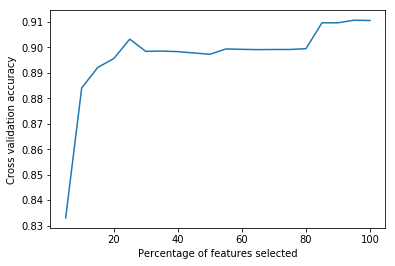

In [413]:
# Decision Tree
treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_leaf = 2, min_samples_split = 20)

percentiles = range(5, 101, 5)
results = []
for i in range(5, 101, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    train_norm_fs = fs.fit_transform(train_norm, target_train)
    scores = cross_validation.cross_val_score(treeclf, train_norm_fs, target_train, cv=5)
    print(i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = int(np.where(results == results.max())[0])
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile]), "\n")
optimal_num_features = int(percentiles[optimal_percentile]*len(df_final.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

In [414]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=95)
X_train_fs = fs.fit_transform(train_norm, target_train)

In [415]:
np.set_printoptions(suppress=True, precision=2, linewidth=80)
print(fs.get_support())
print(fs.scores_)

[ True  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True  True]
[    2.8    282.93   209.89     0.14   182.81   425.56  2443.03   147.37
    62.27     2.38   705.92   206.7    354.77    40.29     9.83    17.61
    41.19     1.73    71.44   104.92     8.72    18.07     0.85     5.92     9.6
     5.84     0.21    43.67    14.49    63.78    58.09    73.97     2.69
    75.52  1066.1    177.8      0.57     0.27     0.29   706.38   151.17
     0.15    40.66   134.89   763.65   105.22   124.98     4.3    110.34
   395.27    80.76   188.9 ]


In [416]:
df_final.columns[fs.get_support()].values

array(['AgeatInquiry', 'Veteran', 'ProvidedEmail', 'RequestedVisit', 'NoCall',
       'NoEmail', 'PersonalLetter', 'Call', 'Email', 'Tour', 'Visit',
       'Assessment', 'CommunityEvent', 'MassCommunication', 'TextMessage',
       'ShortStay', 'Gift', 'CareLevel_A', 'CareLevel_F', 'CareLevel_I',
       'CareLevel_M', 'CareLevel_S', 'Gender_Female', 'Gender_Male',
       'Marital_Divorced', 'Marital_Single', 'Marital_Unknown', 'Marital_Widow',
       'CurrentResidence_Living at Home', 'CurrentResidence_Living with Family',
       'CurrentResidence_Rental Apartment', 'CurrentResidence_Senior Community',
       'UnitPreference_1 Bed', 'UnitPreference_2 Bed', 'UnitPreference_3 Bed',
       'UnitPreference_Cottage/Villa', 'UnitPreference_Semi-Private',
       'UnitPreference_Studio', 'UnitPreference_Unknown', 'Budget_1,000-2,000',
       'Budget_2,000-3,000', 'Budget_3,000-4,000', 'Budget_4,000-5,000',
       'Budget_5,000 +', 'ReferralCompany_A Place for Mom',
       'ReferralCompany_Carin

In [417]:
fs = feature_selection.SelectKBest(feature_selection.chi2, optimal_num_features)
train_fs = fs.fit_transform(train, target_train)
treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, min_samples_leaf = 2, min_samples_split = 20)
treeclf.fit(train_fs, target_train)
test_fs = fs.transform(test)

In [418]:
treepreds_test = treeclf.predict(test_fs)
print(classification_report(target_test, treepreds_test))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94      3661
          1       0.85      0.75      0.80      1082

avg / total       0.91      0.91      0.91      4743



5 0.82085637319
10 0.867513471602
15 0.877477641373
20 0.893557535515
25 0.896457030895
30 0.897880608801
35 0.897986010631
40 0.898249640287
45 0.900253025543
50 0.900622196008
55 0.902045523751
60 0.902941689467
65 0.902889030246
70 0.903047188583
75 0.903099903396
80 0.903099889498
85 0.90557790264
90 0.905736074874
95 0.905683401755
100 0.905894219313
Optimal percentile of features:100 

Optimal number of features:52 



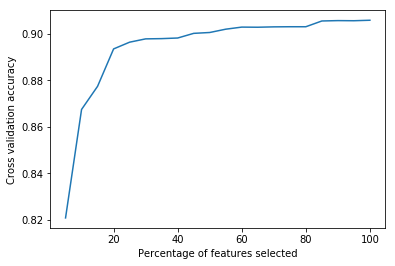

In [419]:
# Logistic Regression  
LRclf = LogisticRegression(penalty = 'l1')

percentiles = range(5, 101, 5)
results = []
for i in range(5, 101, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    train_norm_fs = fs.fit_transform(train_norm, target_train)
    scores = cross_validation.cross_val_score(LRclf, train_norm_fs, target_train, cv=5)
    print(i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = int(np.where(results == results.max())[0])
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile]), "\n")
optimal_num_features = int(percentiles[optimal_percentile]*len(df_final.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

I don't have to reduce features for logistics regression

5 0.832981822493
10 0.884067826856
15 0.89303042908
20 0.897353363387
25 0.903416359048
30 0.90346887929
35 0.901202045051
40 0.901517958685
45 0.902836023577
50 0.90220352921
55 0.905050532144
60 0.906473873785
65 0.907475635903
70 0.908002936909
75 0.909426389733
80 0.908213851752
85 0.916754540902
90 0.917176287201
95 0.916332794604
100 0.917492603874
Optimal percentile of features:100 

Optimal number of features:52 



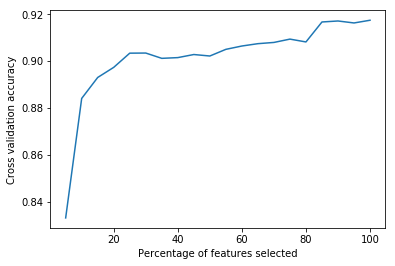

In [420]:
# Random Forest
RFclf = RandomForestClassifier(criterion = 'gini', max_depth = 20, min_samples_leaf = 1, n_estimators = 85)

percentiles = range(5, 101, 5)
results = []
for i in range(5, 101, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    train_norm_fs = fs.fit_transform(train_norm, target_train)
    scores = cross_validation.cross_val_score(RFclf, train_norm_fs, target_train, cv=5)
    print(i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = int(np.where(results == results.max())[0])
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile]), "\n")
optimal_num_features = int(percentiles[optimal_percentile]*len(df_final.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

I don't have to reduce features for random forest

5 0.817007816607
10 0.844317049927
15 0.844369625761
20 0.858551286315
25 0.859395056871
30 0.854597327902
35 0.854333865021
40 0.853859348318
45 0.851750658518
50 0.851908719569
55 0.846636751856
60 0.846847555516
65 0.845107883304
70 0.845107952793
75 0.844791622222
80 0.842735522154
85 0.843315385095
90 0.841733885118
95 0.840363327779
100 0.840257912051
Optimal percentile of features:25 

Optimal number of features:13 



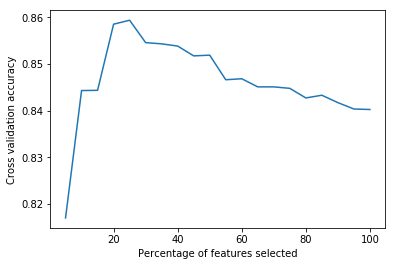

In [421]:
# Naive Bayes
NBclf = naive_bayes.GaussianNB()

percentiles = range(5, 101, 5)
results = []
for i in range(5, 101, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    train_norm_fs = fs.fit_transform(train_norm, target_train)
    scores = cross_validation.cross_val_score(NBclf, train_norm_fs, target_train, cv=5)
    print(i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = int(np.where(results == results.max())[0])
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile]), "\n")
optimal_num_features = int(percentiles[optimal_percentile]*len(df_final.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

In [422]:
fs = feature_selection.SelectKBest(feature_selection.chi2, optimal_num_features)
train_fs = fs.fit_transform(train, target_train)
NBclf = naive_bayes.GaussianNB()
NBclf.fit(train_fs, target_train)
test_fs = fs.transform(test)

In [423]:
NBpreds_test = NBclf.predict(test_fs)
print(classification_report(target_test, NBpreds_test))

             precision    recall  f1-score   support

          0       0.89      0.92      0.91      3661
          1       0.70      0.61      0.65      1082

avg / total       0.85      0.85      0.85      4743



5 0.82085637319
10 0.873154665372
15 0.883013419415
20 0.889182080966
25 0.892977825451
30 0.894032316279
35 0.893610528286
40 0.893083227281
45 0.895350214396
50 0.896088360756
55 0.897564500597
60 0.897986246896
65 0.898407965399
70 0.898460708007
75 0.898513436718


/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

80 0.898513436718


/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


85 0.900780479425


/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


90 0.900727778511


/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


95 0.900675035902
100 0.90130765535
Optimal percentile of features:100 

Optimal number of features:52 



/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/yanyu/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


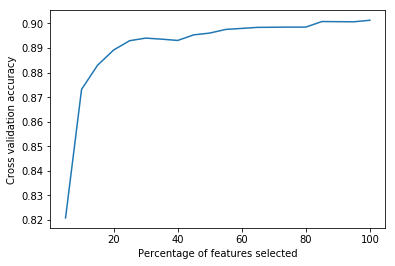

In [424]:
# Linear Discriminant Analysis
LDAclf = LinearDiscriminantAnalysis(n_components = 1)

percentiles = range(5, 101, 5)
results = []
for i in range(5, 101, 5):
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=i)
    train_norm_fs = fs.fit_transform(train_norm, target_train)
    scores = cross_validation.cross_val_score(LDAclf, train_norm_fs, target_train, cv=5)
    print(i,scores.mean())
    results = np.append(results, scores.mean())

optimal_percentile = int(np.where(results == results.max())[0])
print("Optimal percentile of features:{0}".format(percentiles[optimal_percentile]), "\n")
optimal_num_features = int(percentiles[optimal_percentile]*len(df_final.columns)/100)
print("Optimal number of features:{0}".format(optimal_num_features), "\n")

# Plot percentile of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Percentage of features selected")
pl.ylabel("Cross validation accuracy")
pl.plot(percentiles,results)

I don't have to reduce features for random forest

# <font color='blue'> <p>The best model is Decision Tree (criterion = 'entropy', max_depth = 7, min_samples_leaf = 2, min_samples_split = 20) with 49 features. 

# <font color='blue'> <p>Clusting
<font color='blue'> <p>We found a package, kmodes that can calculate the distance between categorical variables.
And we try to group the instances into two clusters

__Kmodes Description__

Python implementations of the k-modes and k-prototypes clustering algorithms. Relies on numpy for a lot of the heavy lifting.

k-modes is used for clustering categorical variables. It defines clusters based on the number of matching categories between data points. (This is in contrast to the more well-known k-means algorithm, which clusters numerical data based on Euclidean distance.) The k-prototypes algorithm combines k-modes and k-means and is able to cluster mixed numerical / categorical data.

__References__

[HUANG97] (1, 2) Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.

[HUANG98] Huang, Z.: Extensions to the k-modes algorithm for clustering large data sets with categorical values, Data Mining and Knowledge Discovery 2(3), pp. 283-304, 1998.

[CAO09] Cao, F., Liang, J, Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.

In [280]:
!pip install kmodes

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [295]:
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=2, init='Cao', verbose=2)
clusters = kproto.fit_predict(train_norm, categorical=[1,2,3,4,5,6,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2473, ncost: 10206.416518131684
Run: 1, iteration: 2/100, moves: 1680, ncost: 9773.597948868515
Run: 1, iteration: 3/100, moves: 1334, ncost: 9678.7759278353
Run: 1, iteration: 4/100, moves: 10, ncost: 9678.775450735293
Run: 1, iteration: 5/100, moves: 0, ncost: 9678.775450735293


In [296]:
from sklearn.metrics import completeness_score, homogeneity_score
print('Completeness is ', completeness_score(target_train,clusters))
print('Homogeneity is ', homogeneity_score(target_train,clusters))

Completeness is  0.00201730340487
Homogeneity is  0.00230480552456
